In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle

from jax import jit
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm

In [2]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=np.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
# truncate the timepoints to only keep the non intertrial part
# lin_endpoints = [15,205]
# fr = fr.query(f'{lin_endpoints[1]}>=lin>={lin_endpoints[0]}')

fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

2022-07-05 16:55:04.816257: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


In [140]:
inds = regressors['trial_inds_int']==0
regressors_sim = {'trial_inds_int':regressors['trial_inds_int'][inds],'position':regressors['position'][inds],'dt':regressors['dt']}



In [141]:
nrep = 20
for key in ['trial_inds_int','position']:
    regressors_sim[key] = numpy.tile(regressors_sim[key],nrep)

In [233]:
# pars_sim = {'logws':numpy.random.rand(1,1)*100+100,'mus':numpy.random.rand(1,1)*50+15,'logsigmas':numpy.random.rand(1,1)*3+5,'logb':numpy.random.rand(1,)*2}
pars_sim = {'logws':numpy.random.rand(1,1)*100+100,'mus':numpy.random.rand(1,1)*100+15,'logsigmas':numpy.random.rand(1,1)*3+5,'logb':numpy.array([0])}
target_rate = glm.forward(regressors_sim,pars_sim)
target_spk = numpy.random.poisson(target_rate)

In [246]:
fr_map_func = lambda x:scipy.stats.norm.pdf(x,loc=numpy.squeeze(pars_sim['mus']),scale=gm.softplus(numpy.squeeze(pars_sim['logsigmas']))) * gm.softplus(numpy.squeeze(pars_sim['logws']))




In [234]:
fr_map_target = gm.gm_func_by_trial({'xs':np.arange(220)},pars_sim)

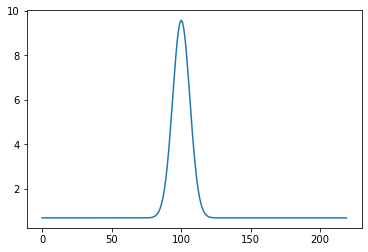

In [235]:
plt.plot(fr_map_target)

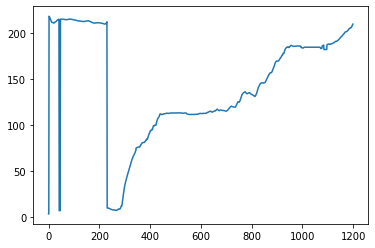

In [239]:
plt.plot(regressors_sim['position'][:1200])

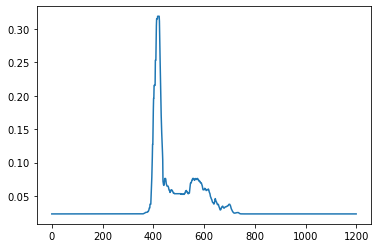

In [236]:
plt.plot(target_rate[:1200])

In [255]:
fr_map_func(113) * 0.033, fr_map_func(111) * 0.033

(DeviceArray(0.03270131, dtype=float32),
 DeviceArray(0.06119304, dtype=float32))

In [254]:
regressors_sim['position'][500],regressors_sim['position'][550]

(113.254944, 111.86786)

In [240]:
target_rate[500]

DeviceArray(0.05337109, dtype=float32)

In [241]:
target_rate[550]

DeviceArray(0.07081266, dtype=float32)

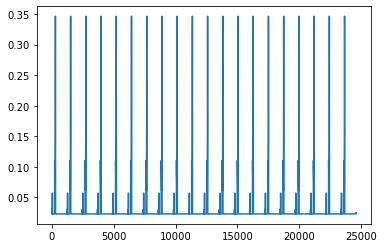

In [226]:
plt.plot(target_rate)

In [147]:
regressors_sim_df = {'trial_inds_int':regressors_sim['trial_inds_int'],'position':regressors_sim['position']}

regressors_sim_df = pd.DataFrame(regressors_sim_df)

regressors_sim_df['target_spk'] = target_spk

In [165]:
pd.cut(regressors_sim_df['position'],bins=100,retbins=True,labels=False)[0]

0         1
1         1
2        98
3        98
4        98
         ..
24595     0
24596     0
24597     0
24598     0
24599     0
Name: position, Length: 24600, dtype: int64

In [166]:
posbin = pd.cut(regressors_sim_df['position'],bins=100,retbins=True,labels=False)[0]
regressors_sim_df['position_bin']=posbin

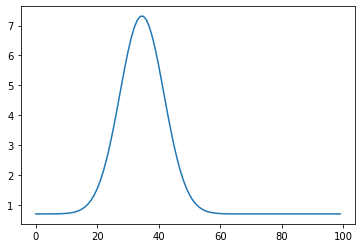

In [170]:
plt.plot(fr_map_target)

<AxesSubplot:xlabel='position_bin'>

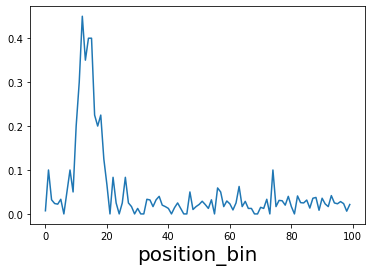

In [169]:
regressors_sim_df.groupby('position_bin')['target_spk'].mean().plot()

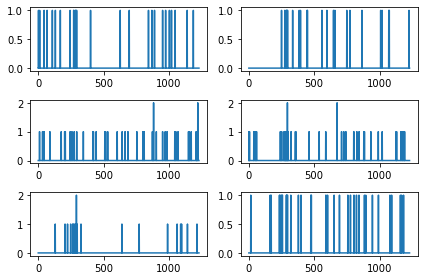

In [227]:
fig=plt.figure()
for i in range(6):
    ax=fig.add_subplot(3,2,i+1)
    ax.plot(target_spk.reshape(nrep,-1)[i])
plt.tight_layout()

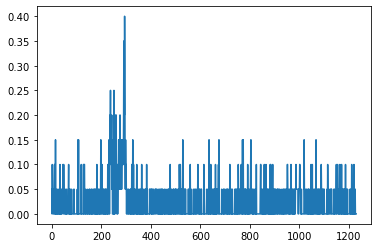

In [228]:
plt.plot(target_spk.reshape(nrep,-1).mean(axis=0))

In [229]:
%%time

regressors=regressors_sim
target = target_spk
# pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)
pars_sim_init = {'logws':numpy.random.rand(1,1)*100+100,'mus':numpy.random.rand(1,1)*50+15,'logsigmas':numpy.random.rand(1,1)*3+5,'logb':numpy.array([0.1])}
# pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=False)

sampler_func = blackjax.mala
sampler_kw = {'step_size':1e-2}
states=glm.fit(regressors,pars_sim_init,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=10000,rng_key_int=0)


CPU times: user 3.64 s, sys: 10.1 ms, total: 3.65 s
Wall time: 3.64 s


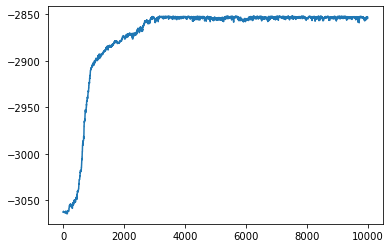

In [230]:
plt.plot(states.logprob)

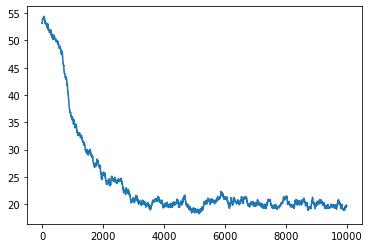

In [231]:
plt.plot(states.position['mus'][:,0,0])

In [243]:
states.position['logws'][7000:].mean()

DeviceArray(161.37108, dtype=float32)

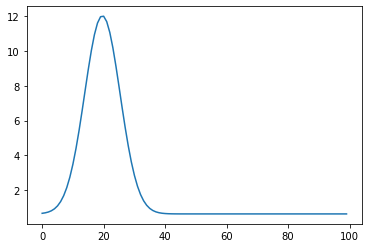

In [244]:
par_end = jax.tree_map(lambda x:x[-1,...],states.position)
plt.plot(gm.gm_func_by_trial({'xs':np.arange(100)},par_end))

In [247]:
numpy.arange(nrep).repeat(len(inds))

array([ 0,  0,  0, ..., 19, 19, 19])

{'trial_inds_int': array([0, 0, 0, ..., 0, 0, 0]),
 'position': array([  3.1310937 ,   3.1310937 , 218.72816   , ...,   0.9840581 ,
          0.89459825,   0.7156786 ], dtype=float32),
 'dt': 0.033333333333757764}

In [252]:
pars_sim_init

{'logws': array([[135.56118765],
        [143.43796893],
        [127.82222256],
        [138.58953246],
        [134.61362687],
        [174.87465579],
        [110.45288586],
        [123.53851655],
        [171.63153937],
        [162.02175186],
        [106.32723342],
        [177.28893768],
        [189.57429155],
        [156.30799789],
        [148.31903937],
        [197.17372782],
        [167.1853231 ],
        [126.85216276],
        [165.62899922],
        [147.1644014 ]]),
 'mus': array([[25.91707512],
        [57.92221915],
        [54.62738418],
        [33.04358594],
        [22.88552447],
        [22.02046149],
        [35.38083785],
        [54.57599817],
        [46.64742399],
        [60.08720759],
        [23.48931406],
        [32.16112173],
        [25.57346103],
        [60.87521381],
        [48.18968835],
        [52.13035592],
        [56.92206882],
        [29.58982605],
        [33.25820641],
        [31.50459527]]),
 'logsigmas': array([[7.25163733],
     

In [253]:
len(inds)

55038

In [258]:
len(regressors_sim['position'])

24600

In [261]:
%%time
# instead, fit individual trials
npars=nrep
regressors=regressors_sim
regressors['trial_inds_int'] = numpy.arange(nrep).repeat(inds.sum())
target = target_spk
# pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)
pars_sim_init = {'logws':numpy.random.rand(npars,1)*100+100,'mus':numpy.random.rand(npars,1)*50+15,'logsigmas':numpy.random.rand(npars,1)*3+5,'logb':numpy.ones(npars)*0.1}
# pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=False)

sampler_func = blackjax.mala
sampler_kw = {'step_size':1e-2}
states=glm.fit(regressors,pars_sim_init,target,sampler_func=sampler_func,sampler_kw=sampler_kw,mask=None,num_samples=20000,rng_key_int=0)


CPU times: user 17.6 s, sys: 1.48 ms, total: 17.6 s
Wall time: 17.6 s


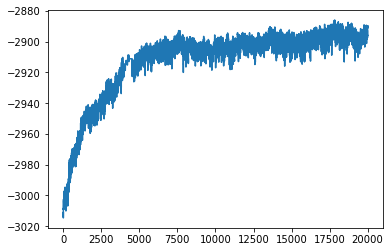

In [262]:
plt.plot(states.logprob)

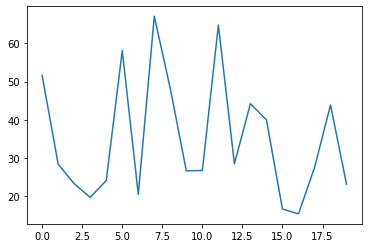

In [272]:
plt.plot(states.position['mus'][10000:,:,0].mean(axis=0))

In [273]:
pars_sim

{'logws': array([[138.6199675]]),
 'mus': array([[18.78735341]]),
 'logsigmas': array([[5.6845577]]),
 'logb': array([0])}

In [ ]:
#
regressors_sim = {'trial_inds_int':numpy.ones(100,dtype=int)*0,'position':numpy.arange(100),'dt':1.0}
# pars_sim = {'logws':numpy.random.rand(1,1)*100+100,'mus':numpy.random.rand(1,1)*50+15,'logsigmas':numpy.random.rand(1,1)*3+5,'logb':numpy.array([0])}
pars_sim = {'logws':numpy.array([[gm.inv_softplus(1.0)]]),'mus':numpy.ones((1,1))*50,'logsigmas':numpy.random.rand(1,1)*3+5,'logb':numpy.array([0])}
target_rate = glm.forward(regressors_sim,pars_sim)
target_spk = numpy.random.poisson(target_rate)


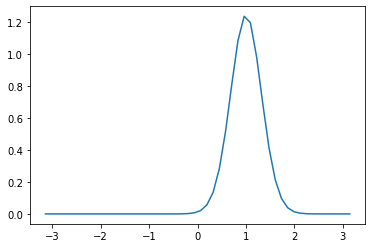

In [90]:
kappa = 10
rv=scipy.stats.vonmises(kappa,loc=1)
fig,ax=plt.subplots()
x = numpy.linspace(-numpy.pi,numpy.pi)
target_rate = rv.pdf(x)
ax.plot(x,target_rate) 

In [137]:
target_spk = numpy.random.poisson(target_rate*10)

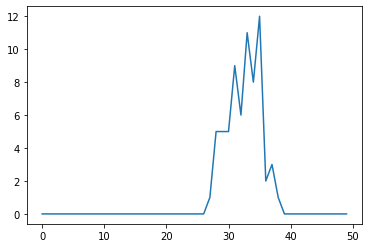

In [138]:
plt.plot(target_spk)

In [80]:
numpy.sum(rv.pdf(x) * numpy.diff(x)[0])

1.0093906857135977

In [78]:
1/numpy.diff(x)[0]

7.798592211502876